<hr style="border:2px solid gray"> </hr>

# Machine Learning
<hr style="border:2px solid gray"> </hr>

# Step 0. Import packages and Global Settings

In [1]:
import os, glob, numpy as np
import tensorflow as tf
from tensorflow.keras import models, layers, callbacks, regularizers, optimizers, callbacks
import matplotlib.pyplot as plt
from keras_preprocessing.image import ImageDataGenerator

Version = 11

train_name = 'train1.hdf5'
test_name = 'test1.hdf5'
category_file_name = 'Categories.txt'
model_dir = './model'
model_name = 'model v{}.h5'.format(Version)

epoch = 50
size_of_val = 3

# Step 1. Data Loading

In [2]:
import h5py
from tensorflow.keras.utils import HDF5Matrix

X_train, X_test, y_train, y_test = HDF5Matrix(train_name, 'X'), HDF5Matrix(test_name, 'X'), HDF5Matrix(train_name, 'y'), HDF5Matrix(test_name, 'y')

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

validate_size = (X_train.shape[0]//10) * size_of_val
print(validate_size)

Instructions for updating:
Training with HDF5Matrix is not optimized for performance. Instead, we recommend using https://github.com/tensorflow/io to load your HDF5 data into a tf.data Dataset and passing that dataset to Keras.
(38488, 300, 300, 3) (38488, 296)
(9597, 300, 300, 3) (9597, 296)
11544


In [3]:
import codecs
category_file = codecs.open(category_file_name, 'r', 'utf-8')
categories = list(map(str.strip, category_file.readlines()))
classes = len(categories)

# Step 2. Define Model

In [4]:
model = None
if os.path.exists(os.path.join(model_dir, model_name)):
    with tf.device('/device:GPU:0'):
        model = models.load_model(os.path.join(model_dir, model_name), compile=True)
else:
    l2_ratio = 0.00
    with tf.device('/device:GPU:0'):
        base_model = tf.keras.applications.resnet_v2.ResNet50V2(weights='imagenet', include_top=False, input_shape=(300, 300, 3))
        x = base_model.output
        x = layers.GlobalAveragePooling2D()(x)
        x = layers.Dropout(0.7)(x)
        predictions = layers.Dense(classes)(x)
        predictions = layers.BatchNormalization()(predictions)
        predictions = layers.Activation('softmax')(predictions)
        model = models.Model(inputs = base_model.input, outputs = predictions)
        model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=1e-5), metrics=['accuracy'])


In [5]:
model.summary()

_________________
conv4_block2_preact_relu (Activ (None, 19, 19, 1024) 0           conv4_block2_preact_bn[0][0]     
__________________________________________________________________________________________________
conv4_block2_1_conv (Conv2D)    (None, 19, 19, 256)  262144      conv4_block2_preact_relu[0][0]   
__________________________________________________________________________________________________
conv4_block2_1_bn (BatchNormali (None, 19, 19, 256)  1024        conv4_block2_1_conv[0][0]        
__________________________________________________________________________________________________
conv4_block2_1_relu (Activation (None, 19, 19, 256)  0           conv4_block2_1_bn[0][0]          
__________________________________________________________________________________________________
conv4_block2_2_pad (ZeroPadding (None, 21, 21, 256)  0           conv4_block2_1_relu[0][0]        
___________________________________________________________________________________________

# Training

In [6]:
#early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=15)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)
model_checkpoint = callbacks.ModelCheckpoint(filepath=os.path.join(model_dir, model_name), monitor='val_loss', save_best_only=True, mode='auto')

datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        # rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')
#validate = datagen.flow(X_train[:validate_size], y_train[:validate_size], batch_size=24)
validate = (X_train[:validate_size], y_train[:validate_size])
train = datagen.flow(X_train[validate_size:], y_train[validate_size:], batch_size=24)

In [7]:
history = model.fit(train, epochs=epoch, validation_data=validate, callbacks=[model_checkpoint, reduce_lr])

Epoch 1/50
1123/1123 [==============================] - 546s 487ms/step - loss: 1.7648 - accuracy: 0.8672 - val_loss: 1.6243 - val_accuracy: 0.7012
Epoch 2/50
1123/1123 [==============================] - 553s 492ms/step - loss: 1.7576 - accuracy: 0.8684 - val_loss: 1.6237 - val_accuracy: 0.7021
Epoch 3/50
1123/1123 [==============================] - 568s 506ms/step - loss: 1.7596 - accuracy: 0.8681 - val_loss: 1.6232 - val_accuracy: 0.7029
Epoch 4/50
1123/1123 [==============================] - 560s 499ms/step - loss: 1.7444 - accuracy: 0.8757 - val_loss: 1.6224 - val_accuracy: 0.7030
Epoch 5/50
1123/1123 [==============================] - 547s 487ms/step - loss: 1.7439 - accuracy: 0.8753 - val_loss: 1.6255 - val_accuracy: 0.7015
Epoch 6/50
1123/1123 [==============================] - 552s 491ms/step - loss: 1.7451 - accuracy: 0.8723 - val_loss: 1.6184 - val_accuracy: 0.7050
Epoch 7/50
1123/1123 [==============================] - 553s 492ms/step - loss: 1.7383 - accuracy: 0.8739 - val_

KeyboardInterrupt: 

In [10]:
model.save(os.path.join(model_dir, model_name))

In [8]:
print("정확도 : %.4f" % (model.evaluate(X_test, y_test)[1]))

361/361 [==============================] - 57s 157ms/step - loss: 1.6214 - accuracy: 0.7064
정확도 : 0.7064


# Test

In [8]:
def plot_history(histories, key='binary_crossentropy'):
    plt.figure(figsize=(16,10))

    for name, history in histories:
        val = plt.plot(history.epoch, history.history['val_'+key],
                    '--', label=name.title()+' Val')
        plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
                label=name.title()+' Train')

    plt.xlabel('Epochs')
    plt.ylabel(key.replace('_',' ').title())
    plt.legend()

    plt.xlim([0,max(history.epoch)])

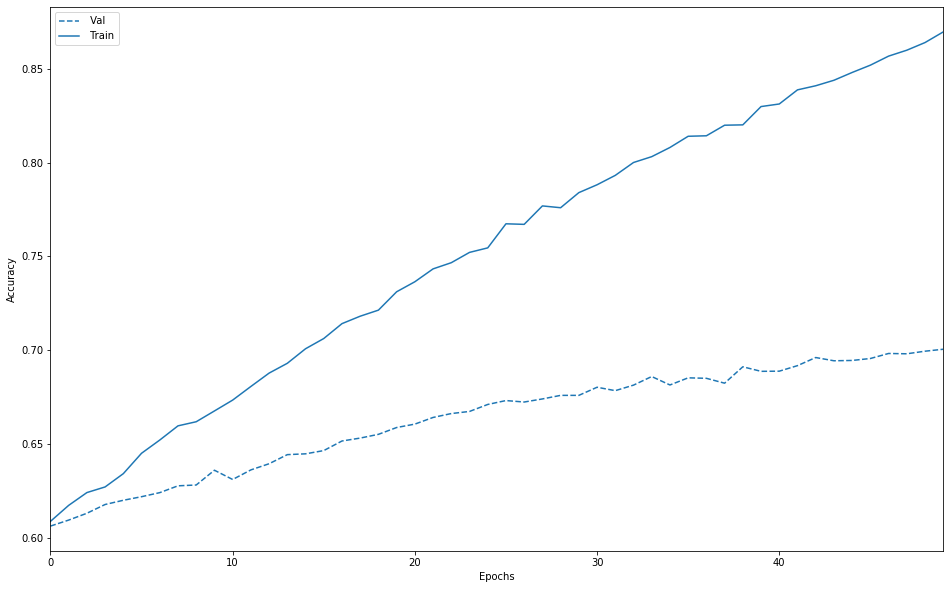

In [9]:
plot_history([('', history)], 'accuracy')

In [5]:
def test_case(model, data, num):
    plt.imshow(data[0][num])
    plt.show()
    print('원본 :', categories[np.argmax(data[1][num])])
    result = model.predict(np.expand_dims(data[0][num], axis=0))
    res_list = np.argsort(-result)[0, :5]
    sum = 0
    for rank, idx in enumerate(res_list):
        if rank == 0 or sum < 0.5: 
            print('#'+str(rank + 1), ':', categories[idx], '(%.2f %%)' % (result[0][idx] * 100))
            sum += result[0][idx]

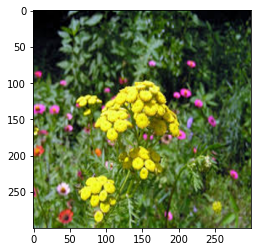

원본 : 탠지
#1 : 탠지 (100.00 %)


In [67]:
random = np.random.randint(0, X_test.shape[0])
test_case(model, (X_test, y_test), random)

In [9]:
print(tf.keras.backend.eval(model.optimizer.lr))    

1e-06
